# House Price Prediction

## Módulos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)
from scipy import stats


from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error



## Carregar datasets (train e test)

In [2]:
train = pd.read_csv('../dataset/train_housing.csv')
test = pd.read_csv('../dataset/test_housing.csv')

## Data information

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Total information

In [5]:
train.shape, test.shape

((1460, 81), (1459, 80))

Uma vez que a variável SalePrice está presente no train dataset mas não do test dataset, será então essa a variável que terá de ser prevista.

Verificando todas as colunas disponíveis no train dataset:

In [6]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Descrição do train datastet

In [7]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Informação do train dataset

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Correlação das restantes variáveis com a target variable (SalePrice)

In [9]:
corr = train.corr()["SalePrice"]
corr[np.argsort(corr, axis=0)[::-1]]

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

Como é possível observar, a maior parte das variáveis tem correlação positiva com a target variable. Estas vão ser as mais importantes para a sua previsão.

Text(0.5, 1.0, 'Correlação entre variáveis e Sale Price')

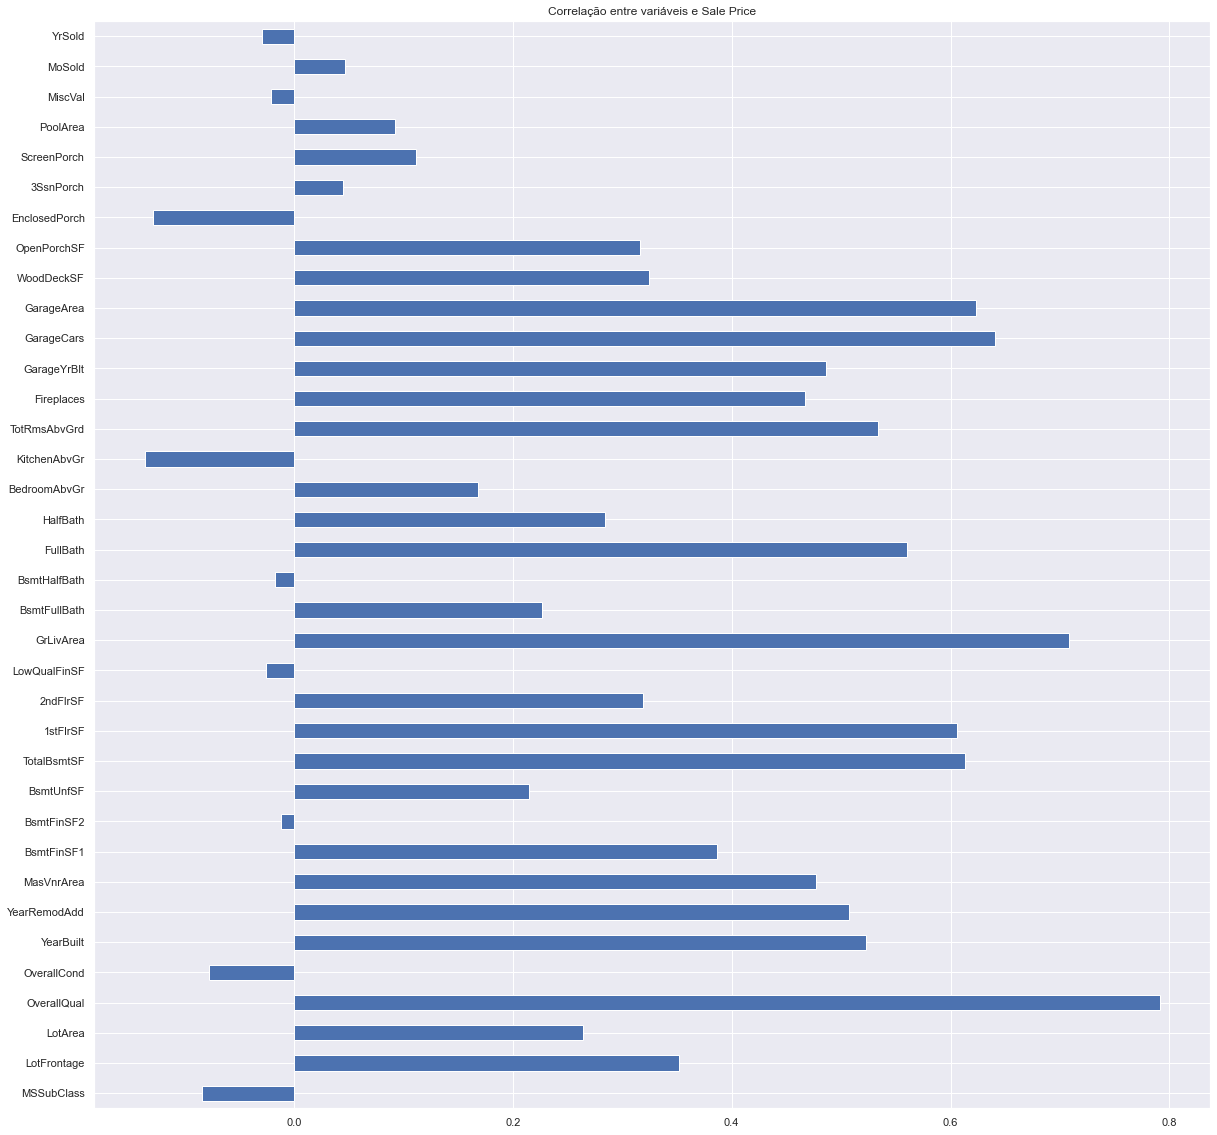

In [10]:
plt.figure(figsize=(20,20))
corr = corr[1:-1] # eliminar (SalePrice) e (Id) do dataset
corr.plot(kind='barh') # using pandas plot
plt.title('Correlação entre variáveis e Sale Price')

In [11]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Selecionando agora apenas as variáveis com correlação positiva, vejamos as relações entre as diferentes variáveis.

<AxesSubplot:>

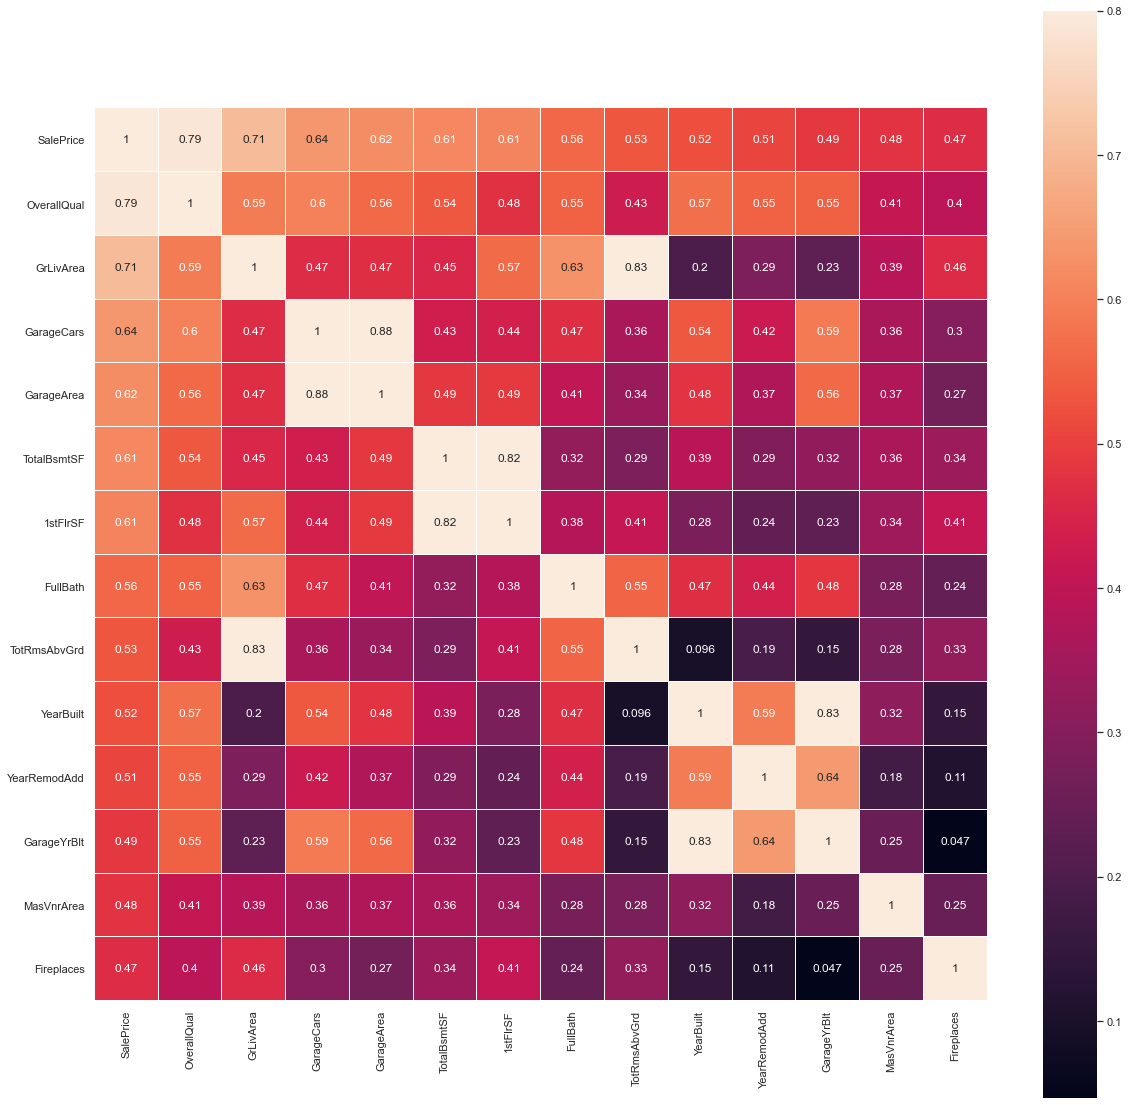

In [12]:
# taking high correlated variables having positive correlation of 45% and above
high_corr_variables = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', \
                               'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', \
                               'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces']

matrix = train[high_corr_variables].corr()

plt.figure(figsize=(20, 20))

sns.heatmap(matrix, vmax=.8, linewidths=0.01,
            square=True, annot=True)

Selecionando algumas das variáveis com maior correlação com SalePrice:

C:\Users\arian\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


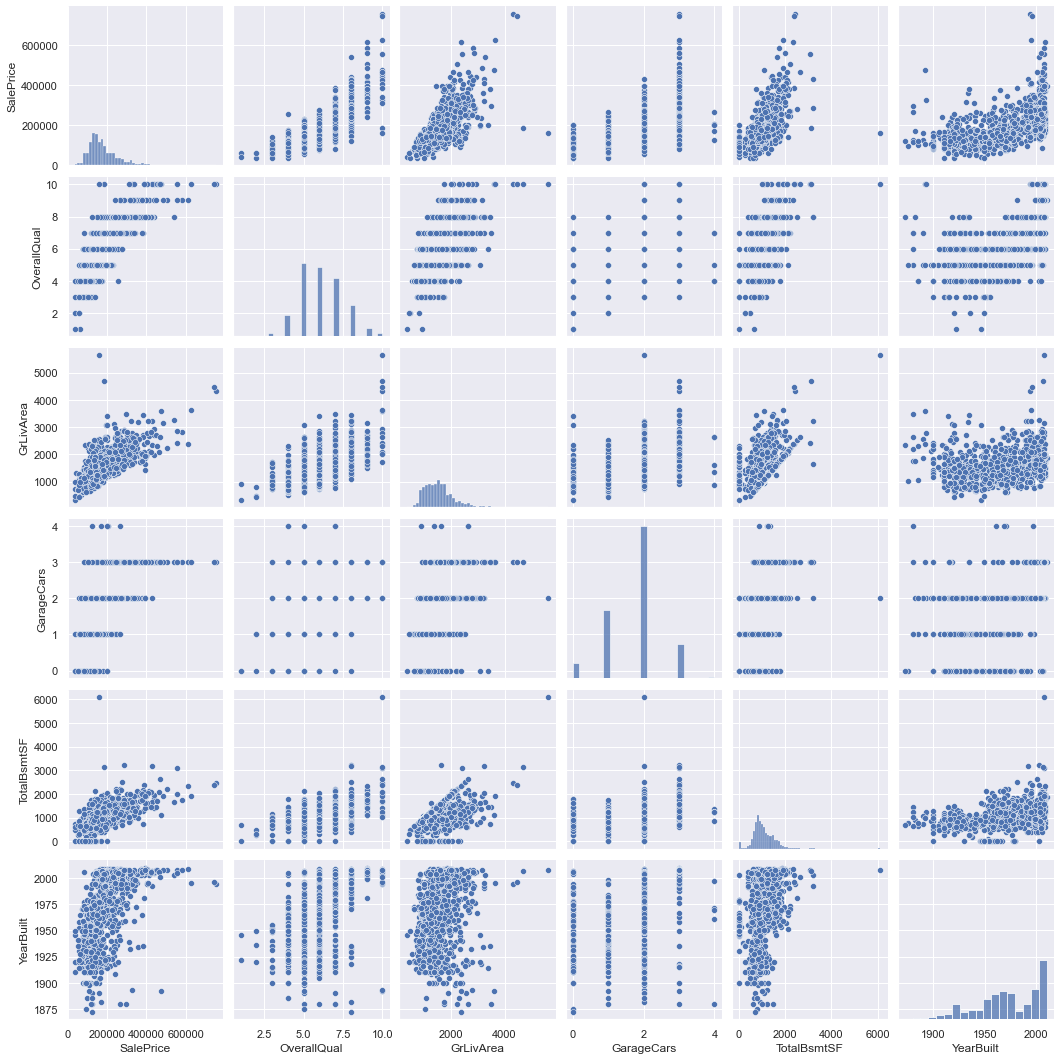

In [13]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)

Com os gráficos de scatter plot anteriores, pode-se concluir os seguintes pontos:

 * As variáveis GrLivArea e TotalBsmtSF estão relacionadas linearmente com a target variable. Quando estas variáveis sofrem um aumento no seu valor, SalePrice também aumenta.

 * As variávies OverallQual e YearBuilt estão relacionadas positivamente com SalePrice.

Para observar a relação entre OverallQual e SalePrice:  

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

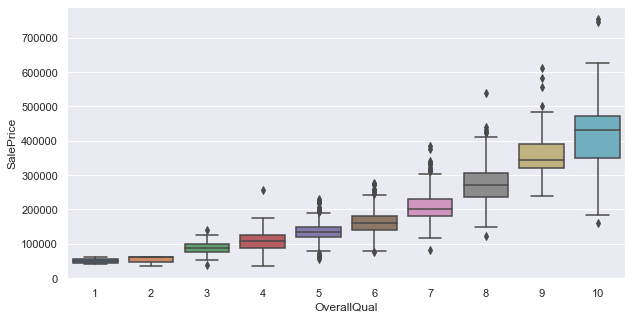

In [14]:
plt.figure(figsize=[10,5])
sns.boxplot(x='OverallQual', y="SalePrice", data=train)

## Missing Values

#### Obtenção dos missing values

Em primeiro lugar, juntar os dois datasets num único - all_data.

In [15]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

(2919, 80)

Listando as variáveis com missing values, calculando a sua percentagem:

In [16]:
null_columns = all_data.columns[all_data.isnull().any()]
total_null_columns = all_data[null_columns].isnull().sum()
percent_null_columns = ( all_data[null_columns].isnull().sum() / all_data[null_columns].isnull().count() )
missing_data = pd.concat([total_null_columns, percent_null_columns], axis=1, keys=['Total', 'Percent']).sort_values(by=['Percent'], ascending=False)
#missing_data.head()
missing_data

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471
GarageYrBlt,159,0.054471


Visualização das percentagens:

Text(0, 0.5, 'Percentagens')

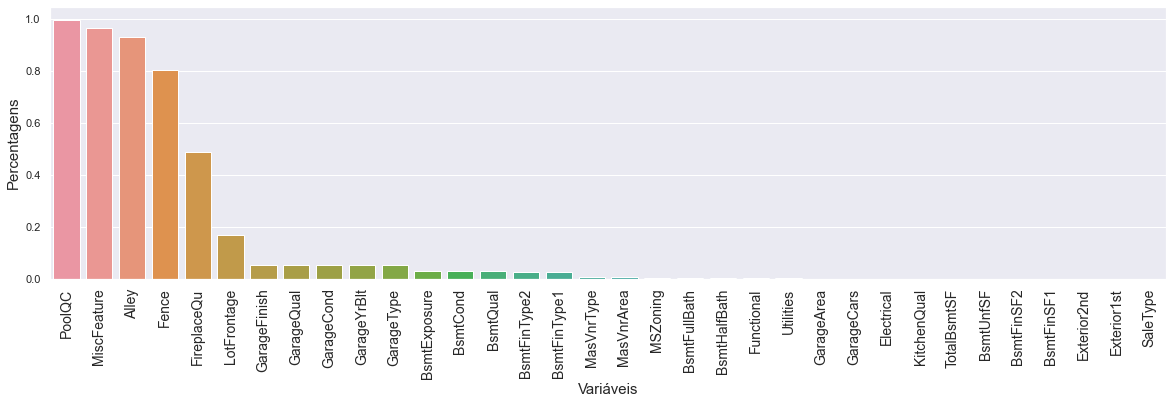

In [17]:
plt.figure(figsize=[20,5])
plt.xticks(rotation='90', fontsize=14)
sns.barplot(x=missing_data.index, y=missing_data.Percent)
plt.xlabel('Variáveis', fontsize=15)
plt.ylabel('Percentagens', fontsize=15)


## Alteração dos missing values

### PoolQC

Uma vez que a maior parte das casas presentes no dataset não têm piscina (+/- 99%) , podemos substituir os valores NULL por, por exemplo, 'None'. 

In [18]:
# valores unicos de PoolQC
all_data['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [19]:
# substituicao de todos os valores NULL por None
all_data['PoolQC'].fillna('None', inplace=True)

### MiscFeature

A maior parte das casas não têm "anotações especiais" (+/- 96%). Podem-se novamente substituir os NULL values por None.

In [20]:
all_data['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [21]:
all_data['MiscFeature'].fillna('None', inplace=True)

### Alley

A maior parte das casas presentes no dataset não possuem acesso através de ruelas (+/- 93%). Podem-se novamente substituir os NULL values por None.

In [22]:
all_data['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [23]:
all_data['Alley'].fillna('None', inplace=True)

### Fence

A maior parte das casas presentes no dataset não possuem qualquer tipo de cerca (+/- 80%). Podem-se novamente substituir os NULL values por None.

In [24]:
all_data['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [25]:
all_data['Fence'].fillna('None', inplace=True)

### FireplaceQu

Aproximadamente 48% das casas presentes no dataset não possuem qualquer tipo de lareira. Podem-se novamente substituir os NULL values por None.

In [26]:
all_data['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [27]:
all_data['FireplaceQu'].fillna('None', inplace=True)

### LotFrontage

LotFrontage: Medição do comprimento de rua conectada à propriedade.

Cerca de 17% dos valores são NULL values. Pode-se assumir que a distância entre a rua da propriedade em questão será a mesma da propriedade vizinha.

Podemos então substituir os NULL values pela mediana da variável LotFrontage no bairro onde se encontra inserida.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'CollgCr'),
  Text(1, 0, 'Veenker'),
  Text(2, 0, 'Crawfor'),
  Text(3, 0, 'NoRidge'),
  Text(4, 0, 'Mitchel'),
  Text(5, 0, 'Somerst'),
  Text(6, 0, 'NWAmes'),
  Text(7, 0, 'OldTown'),
  Text(8, 0, 'BrkSide'),
  Text(9, 0, 'Sawyer'),
  Text(10, 0, 'NridgHt'),
  Text(11, 0, 'NAmes'),
  Text(12, 0, 'SawyerW'),
  Text(13, 0, 'IDOTRR'),
  Text(14, 0, 'MeadowV'),
  Text(15, 0, 'Edwards'),
  Text(16, 0, 'Timber'),
  Text(17, 0, 'Gilbert'),
  Text(18, 0, 'StoneBr'),
  Text(19, 0, 'ClearCr'),
  Text(20, 0, 'NPkVill'),
  Text(21, 0, 'Blmngtn'),
  Text(22, 0, 'BrDale'),
  Text(23, 0, 'SWISU'),
  Text(24, 0, 'Blueste')])

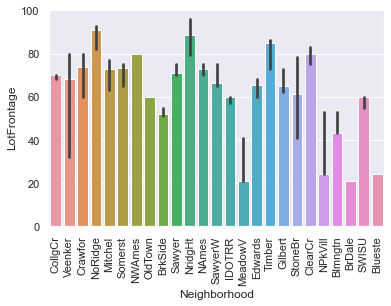

In [28]:
sns.barplot(data=train,x='Neighborhood',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)

In [29]:
all_data['LotFrontage'].unique()


array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.,  26.,  25., 119.,  31.,  28., 117., 113., 125., 135., 136.,
        22., 123., 195., 155., 126., 200., 131., 133.])

In [30]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [31]:
all_data['LotFrontage'].unique()

array([ 65. ,  80. ,  68. ,  60. ,  84. ,  85. ,  75. ,  51. ,  50. ,
        70. ,  72. ,  91. ,  73. ,  66. , 101. ,  57. ,  44. , 110. ,
        98. ,  47. , 108. , 112. ,  74. , 115. ,  67. ,  61. ,  48. ,
        33. ,  64. ,  52. , 100. ,  24. ,  89. ,  63. ,  76. ,  81. ,
        95. ,  69. ,  21. ,  32. ,  78. , 121. , 122. ,  40. , 105. ,
        77. ,  94. ,  34. ,  90. ,  80.5,  55. ,  88. ,  82. ,  71. ,
       120. , 107. ,  92. , 134. ,  62. ,  86. , 141. ,  97. ,  72.5,
        54. ,  41. ,  79. , 174. ,  99. ,  83. ,  43. , 103. ,  93. ,
        30. , 129. , 140. ,  35. ,  37. , 118. ,  87. , 116. , 150. ,
       111. ,  49. ,  96. ,  59. ,  36. ,  56. , 102. ,  58. ,  38. ,
       109. , 130. ,  53. , 137. ,  45. , 106. , 104. ,  42. ,  39. ,
       144. , 114. , 128. , 149. , 313. , 168. , 182. , 138. , 160. ,
       152. , 124. , 153. ,  46. ,  26. ,  25. , 119. ,  31. ,  28. ,
       117. , 113. , 125. , 135. , 136. ,  22. , 123. , 195. , 155. ,
       126. , 200. ,

### GarageType, GarageFinish, GarageQual e GarageCond

Todas estas variáveis podem ser tratadas em conjunto, uma vez que se tratam de variáveis categóricas relacionadas com garagem. Podem-se novamente substituir os NULL values por None.

In [32]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    print (all_data[col].unique())

['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
['RFn' 'Unf' 'Fin' nan]
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']


In [33]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col].fillna('None', inplace=True)

### GarageYrBlt, GarageArea e GarageCars

Estas três variáveis podem ser tratadas em conjunto, uma vez que se tratam de variáveis numéricas relacionadas com garagem. Podem-se substituir os NULL values por '0'.

In [34]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col].fillna(0, inplace=True)

### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 e BsmtFinType2

Todas estas variáveis podem ser tratadas em conjunto, uma vez que se tratam de variáveis categóricas relacionadas com Cave. Podem-se novamente substituir os NULL values por None. 'None' vai indicar que a casa não possui qualquer tipo de Cave.

In [35]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col].fillna('None', inplace=True)

### BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath e BsmtHalfBath

Todas estas variáveis podem ser tratadas em conjunto, uma vez que se tratam de variáveis numéricas relacionadas com Cave. Podem-se substituir os NULL values por '0'.

In [36]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col].fillna(0, inplace=True)

### MasVnrArea e MasVnrType

Estas duas variáveis estão relacionadas com acabamentos exteriores de alvenaria. Um NULL value nestas variáveis indica que a propriedade em questão não possui qualquer acabamento deste tipo.
Uma vez que se tratam de valores numéricos, podem-se substituir estes valores por '0'.

In [37]:
all_data["MasVnrType"].fillna("None", inplace=True)
all_data["MasVnrArea"].fillna(0, inplace=True)

### MSZoning, Utilities, Functional, Exterior2nd, Exterior1st, KitchenQual, Electrical e SaleType

Todas estas variáveis são categóricas. Cada uma possui menos de 5 NULL values, que se podem substituir pelo valor mais comum da variável em questão. 

In [38]:
for col in ('MSZoning', 'Utilities', 'Functional', 'Exterior2nd', 'Exterior1st', 'KitchenQual', 'Electrical', 'SaleType'):
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)

## Recheck de Missing Values

Para ter a certeza que todos os NULL values foram tratados:

In [39]:
null_columns = all_data.columns[all_data.isnull().any()]
print (null_columns)

Index([], dtype='object')


## Remoção de Outliers

Os *outliers* consistem em valores fora da média para uma dada variável num dataset. Estes valores podem influenciar negativamente os cálculos, principalmente quando se pretendem calcular valores como médias e medianas. 
Tendo isto em mente, a sua remoção é necessária para se realizar uma análise mais concisa do dataset.
Analisemos a distribuição da *target variable* ao longo do dataset (com *outliers*)

Text(0, 0.5, 'Ocorrências')

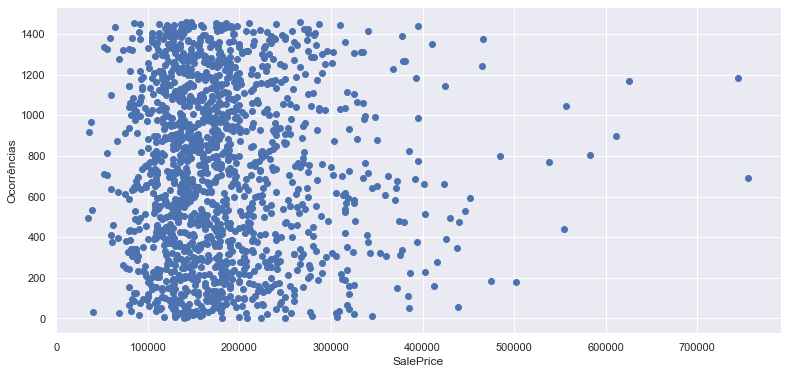

In [40]:
plt.figure(figsize=[13,6])
plt.scatter(train["SalePrice"].values, range(train.shape[0]))
plt.xlabel("SalePrice");
plt.ylabel("Ocorrências")

A partir da análise do gráfico anterior, podemos observar vários *outliers*, nomeadamente a partir do valor 5000000 de SalePrice.
Para a sua remoção alterou-se o *upperlimit* da *target value* de modo a regularizar estes valores:

Text(0, 0.5, 'Ocorrências')

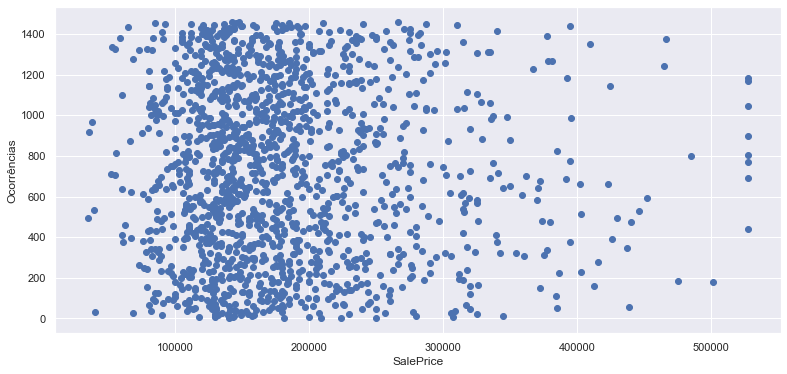

In [41]:
#Regularizaçao dos outliers
upperlimit = np.percentile(train.SalePrice.values, 99.5)
train[train.SalePrice>upperlimit] = upperlimit

#Grafico
plt.figure(figsize=[13,6])
plt.scatter(train["SalePrice"].values, range(train.shape[0]))
plt.xlabel("SalePrice");
plt.ylabel("Ocorrências")

## Converter variáveis categóricas

Irá ser necessário converter as variáveis categóricas referidas anteriormente em dummy-variables. É um passo importante, uma vez que todos os modelos requerem que todos os inputs/output sejam numéricos, então para prevenir que isso aconteca e tentar obter os melhores resultados possíveis, iremos utilizar o pandas e converter essas variáveis categóricas em dummy-variables.

In [42]:
all_data = pd.get_dummies(all_data)

## Atualizar os datasets

Uma vez feito a parte de análise e correção de dados, segue a atualização dos datasets. Para fazermos isso, iremos dar separar o all_data em train e test.

In [43]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Verificação da existência de variáveis categóricas 

Para verificarmos se há a existência de variáveis categóricas, basta apenas procurar por informação com tipo Object

In [44]:
objects = ['O']
train_objects = train.select_dtypes(include=objects)
test_objects = test.select_dtypes(include=objects)
print(f"{train_objects.columns}\n{test_objects.columns}")

Index([], dtype='object')
Index([], dtype='object')


In [45]:
test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1461,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
1462,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
1463,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
1464,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0


In [46]:
train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,0,1,0,0,0,0,1,0


# Modelling

Nesta secção iremos utilizar alguns modelos escolhidos como o Gradient Boosting e XGBoost de forma a treinar os datasets e de seguida tentar criar uma previsão. Iremos também calcular RMSE(Root Mean Square Error) para as previsões, escolhemos RMSE por ser mais usado do que MSE, este calcula a diferença entre os valores previstos pelo modelo e os valores observados. 

In [47]:
x_train = train.drop(['Id'], axis=1)
x_test = test.drop(['Id'], axis=1)

## Gradient Boosting
Iremos utilizar o Gradient Boosting uma vez que é considerado um dos algoritmos mais populares. Este algoritmo irá produzir um modelo de previsão na forma de uma decision tree. 

In [48]:
model_gradientBoosting = GradientBoostingRegressor(n_estimators=2000,learning_rate=0.05,max_depth=4,max_features='sqrt')
model_gradientBoosting.fit(x_train,y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features='sqrt',
                          n_estimators=2000)

## XGBoost

Também decidimos utilizar o XGBoost, uma vez que este implementa algoritmo através de Gradient Boosting, tendo em conta a velocidade e eficiência. 

In [49]:
model_XGB = xgb.XGBRegressor(n_estimators=2200, max_depth=7, learning_rate=0.05, subsample=0.7, colsample_bytree=1)
model_XGB.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2200, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Previsão no Training Data

In [50]:
boosting_train = model_gradientBoosting.predict(x_train)
xgb_train = model_XGB.predict(x_train)

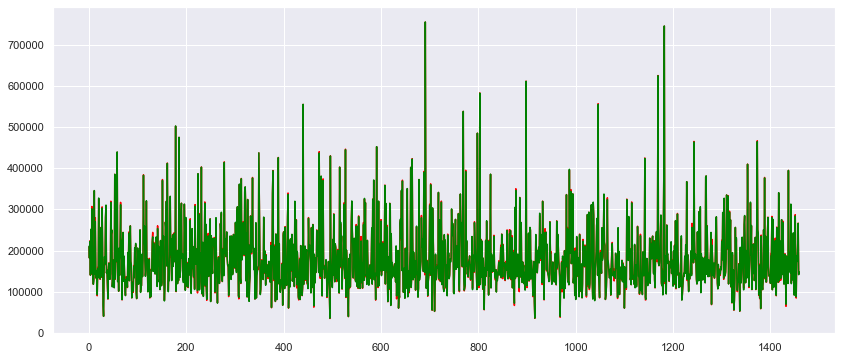

In [51]:
plt.figure(figsize=(14,6))
plt.plot(y_train, color='red')
plt.plot(boosting_train, color='green')
plt.show()

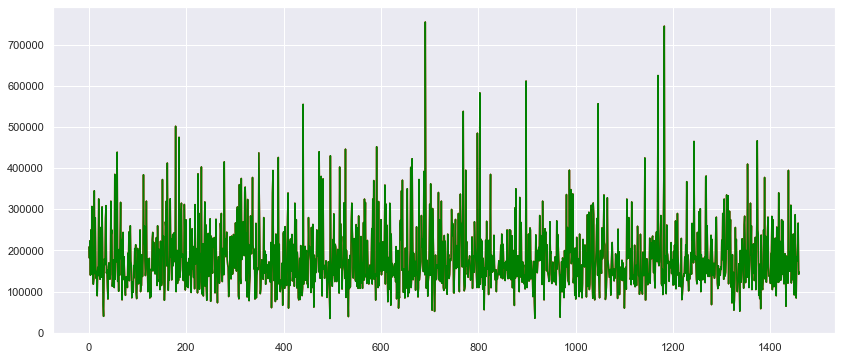

In [52]:
plt.figure(figsize=(14,6))
plt.plot(y_train, color='red')
plt.plot(xgb_train, color='green')
plt.show()

## Previsão no Test Data


In [53]:
boosting_test = model_gradientBoosting.predict(x_test)
xgb_test = model_XGB.predict(x_test)


## Guardar os resultados dos modelos em ficheiros csv

In [54]:
models_train = {"gradient_boosting":boosting_train, "xgb":xgb_train}
models_test = {"gradient_boosting":boosting_test, "xgb":xgb_test}

for key,value in models_train.items():
    pd.DataFrame({"Id":train["Id"],"SalePrice": boosting_train}).to_csv(f'../dataset/submissions/predict_train_house_{key}.csv',index=False)

for key,value in models_test.items():
    pd.DataFrame({"Id":test["Id"],"SalePrice":boosting_test}).to_csv(f'../dataset/submissions/predict_test_house_{key}.csv',index=False)    

